# Pairwise differential analysis to identify cluster enriched genes

This notebook provies a guide on identifying cluster enriched genes by performing differential analysis on pairs of clusters. For each cluster, differential analysis is performed relative to all other clusters and the number of times a gene is differentially expressed is enumerated. Cluster enriched genes are differentiatlly high in the target cluster relative to all/most other clusters

The following packages need to be installed for running this notebook:
1. `scanpy`: https://scanpy.readthedocs.io/en/stable/installation.html
2. `plotly`: https://plotly.com/python/getting-started/
3. `tqdm` : https://github.com/tqdm/tqdm#installation


## Parameters

`Anndata` objects the primary input for this notebook. The data in the `anndata` object should be normalized and log-transformed. The following are the parameters that need to be specified. Defaults below are set according to our manuscript
1. `LEIDEN_NAME` represents the `anndata.obs` field the contains information about clusters for pairwise differential analysis
2. `ARG_PAIRWISE_LOG_FC_MIN`: Is the minimum log FC for a gene to be differentially high in a cluster
3. `ARG_PAIRWISE_PVAL_CUTOFF`: Is the p-value cutoff for a gene to be differentially high in a cluster

In [1]:
LEIDEN_NAME = 'leiden_postBC'
ARG_PAIRWISE_LOG_FC_MIN = 1.5
ARG_PAIRWISE_PVAL_CUTOFF = 1e-25

Now, import the necessary packages along with plotting presets

## Imports

In [2]:
# data related
import anndata as AnnData
import numpy as np
import pandas as pd
import scanpy as sc

# plotly plots -- heatmaps
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# other data vis packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style

# utils -- for loading bar + utility functions
import tqdm
import os
import sys

import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [3]:
# Plotting presets
%matplotlib inline
style.use('ggplot')

# config for matplotlib
matplotlib.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams['figure.dpi'] = 2000
matplotlib.rcParams['image.cmap'] = 'Spectral_r'

# config for scanpy
sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')


scanpy==1.9.1 anndata==0.8.0 umap==0.5.1 numpy==1.21.0 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [4]:
# for deterministic behaviour/reproducibility
seed = 1
np.random.seed(seed)

In [5]:
# helper function import for pairwise analysis
sys.path.append('../utils/')
from pairwise_differential_expression import pairwise_differential_analysis, add_pairwise_results_to_anndata, plot_pairwise_results

## Example data

We use glial cells described in our manuscript as the example for demonstrating pairwise differential results. 

The anndata can be downloaded from the URL below. Replace the path in `line 2` with your anndata object 

In [6]:
ad_url = "https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/worm-glia-atlas/GliaOnly.h5ad"
adata = sc.read("data/GliaOnly.h5ad", backup_url=ad_url)
adata

AnnData object with n_obs × n_vars = 20810 × 12376
    obs: 'Celltype', 'sex_specificity', 'leiden_postBC', 'sex', 'SheathSocket_label', 'Compartments', 'leiden_preBC', 'cluster_sex_label', 'Cluster_Celltype'
    var: 'highly_variable', 'previous_highly_variable', 'transcription_factors', 'transporters'
    uns: 'BatchCorrected_LeidenClusters_colors', 'Compartments_colors', 'Identified_SheathSocket_Markers', 'SheathSocket_label_colors', 'Validations_colors', 'cluster_sex_label_colors', 'dendrogram_Cluster_Celltype', 'gene_validations', 'leiden_noBC_colors', 'leiden_postBC_colors', 'sex_colors', 'sex_frac_Glia_postBC', 'sex_specificity_colors'
    obsm: 'DM_EigenVectors_postBC', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noBC'
    varm: 'cluster_means', 'pairwise_cluster_count'
    layers: 'magic_imputed_postBC'

This anndata object contains several metadata information which we visualize below. `LEIDEN_NAME` is used for pairwise differential analysis

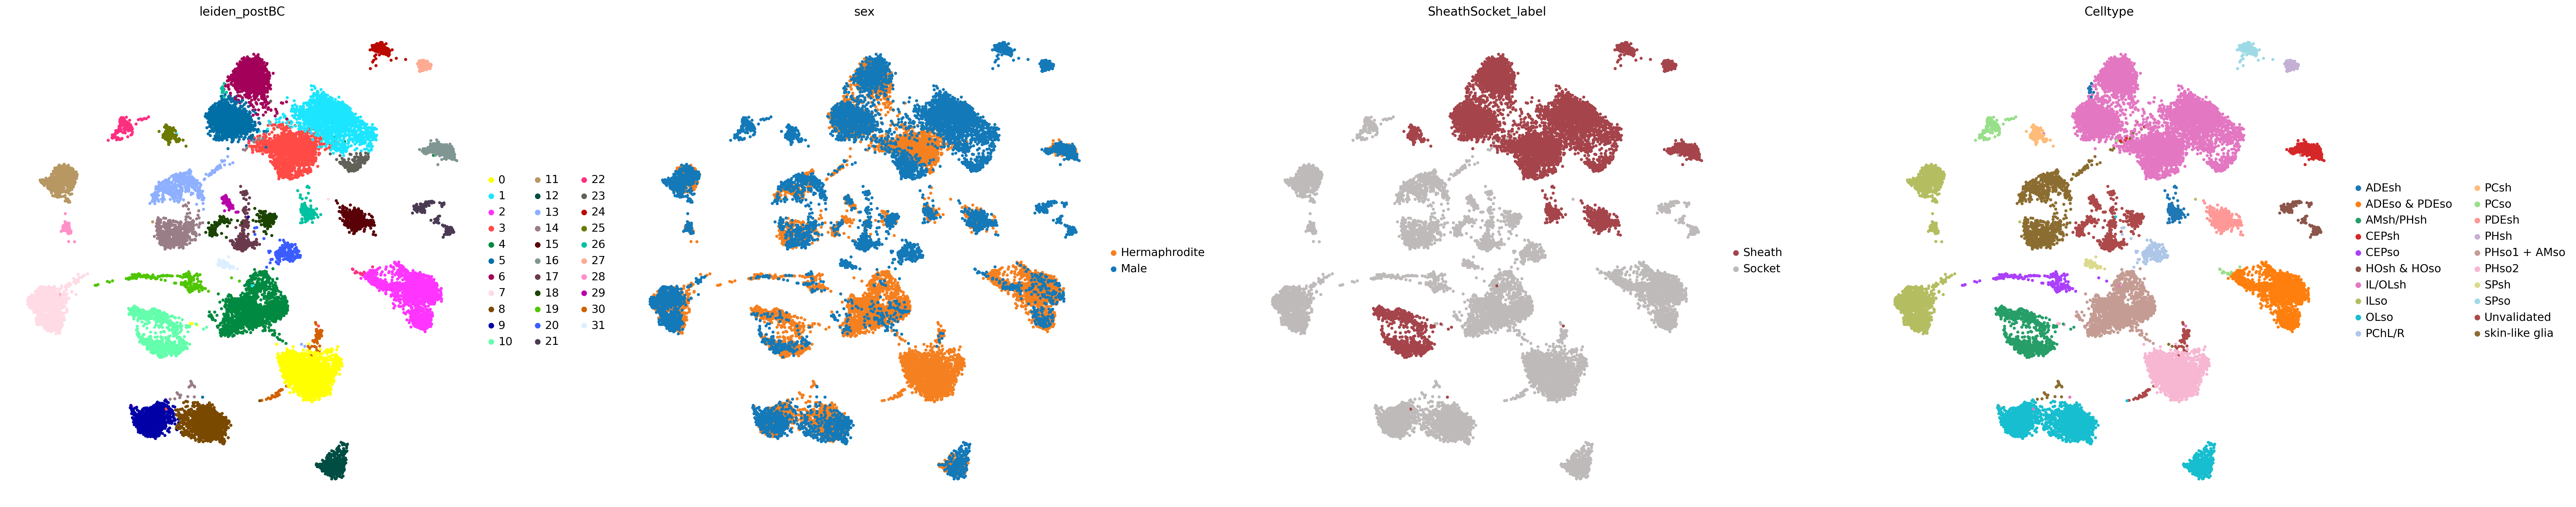

In [7]:
with matplotlib.pyplot.rc_context({'figure.figsize':(10,10)}):
    sc.pl.embedding(
        adata,
        color=[LEIDEN_NAME, 'sex', 'SheathSocket_label', 'Celltype'],
        frameon=False,
        size=50,
        basis='umap',
        wspace=0.2
    )

## Pairwise Differential Expression Analysis 

Pairwise differential expression analysis for each pair of clusters can be performed using the code snippet below. The results are computed in a dataframe and then added to the anndata object. 

<b>NOTE: </b> The anndata object is modified with the following information
1. `adata.varm['pairwise_cluster_count']`: Gene X Cluster matrix indicating how many comparisons the gene is differential.
2. `adata.varm['cluster_means']`: Gene X Cluster matrix of mean expression of gene per cluster.

In [8]:
# package the arguments
clusters = adata.obs[LEIDEN_NAME].unique()

# Pairwise analysis per cluster
# N x (N-1) computation will be done
target_cluster_results = []
for cluster in tqdm.tqdm(clusters):
    result = pairwise_differential_analysis(adata, cluster, 
                                LEIDEN_NAME, ARG_PAIRWISE_LOG_FC_MIN, ARG_PAIRWISE_PVAL_CUTOFF)
    target_cluster_results += result
    
# Consolidate pairwise results via concatenation each pairwise results should be accessible by 'group'
df_mp = pd.concat(target_cluster_results, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [03:38<00:00,  6.82s/it]


In [9]:
# df_mp_GroupCounts = df_mp.loc[:,['names','group']].groupby(['group','names']).agg({'names':'count'}).rename(columns={'names':'gene_counts'})

In [10]:
# leiden_name = LEIDEN_NAME
# pairwise_counts_matrix = pd.DataFrame(0, index=adata.var_names, columns=adata.obs[leiden_name].values.categories)
# cluster_list = adata.obs[leiden_name].values.categories.tolist()
# for cluster in tqdm.tqdm(cluster_list, total=len(cluster_list), desc='Adding count values'):
#     clust_specific_genes = df_mp_GroupCounts.loc[cluster,:].index.tolist()
#     clust_specific_genes_count = df_mp_GroupCounts.loc[cluster].values.ravel()
#     pairwise_counts_matrix.loc[clust_specific_genes,cluster] = clust_specific_genes_count

In [11]:
# Add to anndata
add_pairwise_results_to_anndata(adata, df_mp, LEIDEN_NAME)

Adding count values: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1392.83it/s]


Results can be visualized with the `plot_pairwise_results` function

## Plot

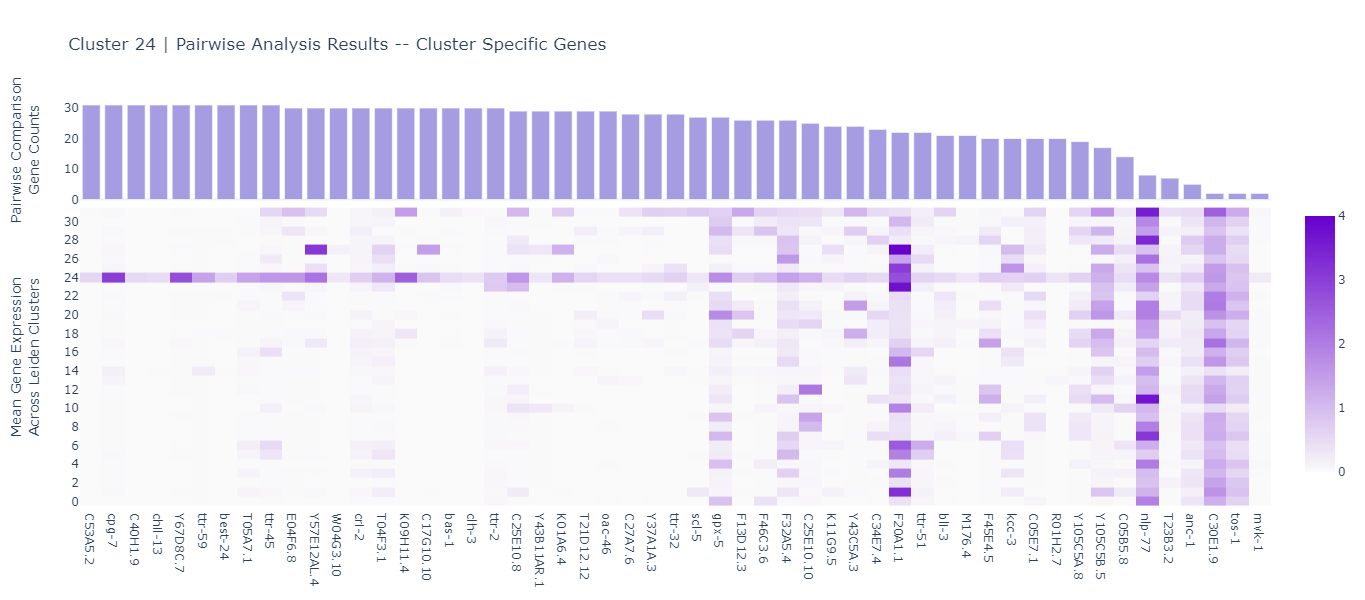

In [15]:
plot_pairwise_results(adata, '24', save=None)

Specify the `save` parameter with a png filename to save the image

Save the anndata object with the pairwise differential analysis results 
`adata.write(<Path>)`